# Credmark Modeling Framework Notebook - Uniswap FEI/TRIBE pool TVL

version: 2022.7.7


## Initialize

<div class="alert alert-block alert-info">
    <b>Note:</b> Change to a web3 provider you have in `params`/`chain_to_provider_url` below.
</div>


In [11]:
%reload_ext credmark.cmf.ipython

cmf_param = {
    'chain_id': 1,
    'block_number': None,
    'chain_to_provider_url': {},
    'api_url': None,
    'use_local_models': None,
    'register_utility_global': True}

context, model_loader = %cmf cmf_param

from models.dtos.tvl import TVLInfo
from models.dtos.price import PoolPriceInfo
from models.credmark.protocols.dexes.uniswap.uniswap_v3_pool import UniswapV3PoolInfo

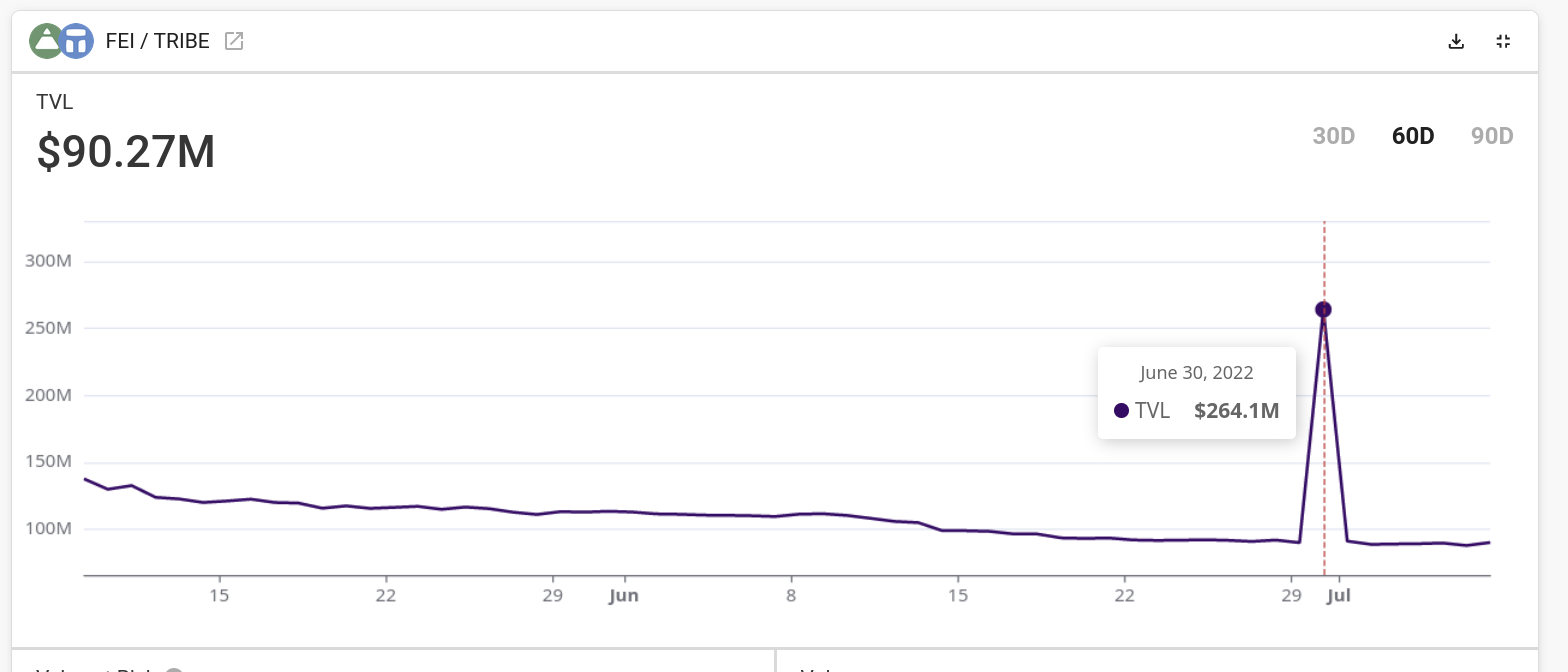


In [12]:
fei_tribe_pool = Contract(address='0x9928e4046d7c6513326cCeA028cD3e7a91c7590A')

## 1. TVL of past block numbers


In [13]:
block_20220629 = BlockNumber.from_ymd(2022, 6, 29)
block_20220630 = BlockNumber.from_ymd(2022, 6, 30)
block_20220701 = BlockNumber.from_ymd(2022, 7, 1)

block_20220629, block_20220630, block_20220701

(15042265, 15047598, 15053226)

In [14]:
res = context.models.compose.map_blocks(
    modelInput=fei_tribe_pool,
    blockNumbers=[block_20220629, block_20220630, block_20220701],
    modelSlug = 'uniswap-v2.pool-tvl',
    return_type = MapBlocksOutput[TVLInfo])

res.to_dataframe(
    fields=[('amount0', lambda r: r.portfolio[0].amount),
            ('amount1', lambda r: r.portfolio[1].amount),
            ('price0', lambda r: r.prices[0].price),
            ('price1', lambda r: r.prices[1].price),
            ('price0.src', lambda r: r.prices[0].src),
            ('price1.src', lambda r: r.prices[1].src),])

,blockNumber,blockTime,amount0,amount1,price0,price1,price0.src,price1.src,error
0,15042265,2022-06-28 23:59:51,4.571078e+07,2.911350e+08,0.998478,0.154525,"sushiswap,uniswap-v2,uniswap-v3","uniswap-v2,uniswap-v3",None
1,15047598,2022-06-30 00:00:00,4.554411e+07,2.922036e+08,0.998492,0.154512,"sushiswap,uniswap-v2,uniswap-v3","uniswap-v2,uniswap-v3",None
2,15053226,2022-07-01 00:00:00,4.536528e+07,2.933625e+08,0.998760,0.156688,"sushiswap,uniswap-v2,uniswap-v3","uniswap-v2,uniswap-v3",None


## 2. Price of past blocks


In [15]:
context.models(15047598-10).price.quote(base='0x956f47f50a910163d8bf957cf5846d573e7f87ca'),\
context.models(15047598-10).price.quote(base='0xc7283b66eb1eb5fb86327f08e1b5816b0720212b')

({'src': 'cex|chainlink.price-by-registry|FEI / USD|0x1D244648d5a63618751d006886268Ae3550d0Dfd|v4|True|t:2650s|r:0',
  'price': 0.99868917,
  'quoteAddress': '0x0000000000000000000000000000000000000348'},
 {'src': 'cex|(chainlink.price-by-registry|TRIBE / ETH|0xc1D757bee6BCDD45093979bFE60d341B833B2dB0|v4|True|t:36685s|r:0,chainlink.price-by-registry|ETH / USD|0x37bC7498f4FF12C19678ee8fE19d713b87F6a9e6|v4|True|t:49s|r:0)',
  'price': 0.1528340705990112,
  'quoteAddress': '0x0000000000000000000000000000000000000348'})

In [16]:
Some[PriceWithQuote](
    some=[
        context.models(15047598).price.quote(base='0xc7283b66eb1eb5fb86327f08e1b5816b0720212b'),
        context.models(15047598).price.dex_blended(address='0xc7283b66eb1eb5fb86327f08e1b5816b0720212b'), 
        context.models().price.dex_blended(address='0xc7283b66eb1eb5fb86327f08e1b5816b0720212b'),
        context.models(15047598).price.quote(base='0x956f47f50a910163d8bf957cf5846d573e7f87ca'),
        context.models(15047598).price.dex_blended(address='0x956f47f50a910163d8bf957cf5846d573e7f87ca'), 
        context.models().price.dex_blended(address='0x956f47f50a910163d8bf957cf5846d573e7f87ca')
    ]
).to_dataframe()

,price,src,quoteAddress
0,0.152834,cex|(chainlink.price-by-registry|TRIBE / ETH|0...,0x0000000000000000000000000000000000000348
1,0.154512,"uniswap-v2,uniswap-v3|Non-zero:5|Zero:4|4.0",0x0000000000000000000000000000000000000348
2,0.281134,"uniswap-v2,uniswap-v3|Non-zero:6|Zero:6|4.0",0x0000000000000000000000000000000000000348
3,0.998689,cex|chainlink.price-by-registry|FEI / USD|0x1D...,0x0000000000000000000000000000000000000348
4,0.998492,"uniswap-v2,sushiswap,uniswap-v3|Non-zero:9|Zer...",0x0000000000000000000000000000000000000348
5,0.997082,"uniswap-v2,sushiswap,uniswap-v3|Non-zero:10|Ze...",0x0000000000000000000000000000000000000348


## 3. Uniswap V2 information


In [17]:
df = context.models.uniswap_v2.get_pool_info_token_price(
    address='0xc7283b66eb1eb5fb86327f08e1b5816b0720212b',
    return_type=Some[PoolPriceInfo]
).to_dataframe()

display(df)

info = context.models.uniswap_v2.get_pool_price_info(
    address='0x7ce01885a13c652241ae02ea7369ee8d466802eb',
    token='0xc7283b66eb1eb5fb86327f08e1b5816b0720212b',
    price_slug='uniswap-v2.get-weighted-price',
    protocol='uniswap-v2')

display(info)

,src,price0,price1,one_tick_liquidity0,one_tick_liquidity1,full_tick_liquidity0,full_tick_liquidity1,token0_address,token1_address,token0_symbol,token1_symbol,pool_address,ref_price,tick_spacing
0,uniswap-v2.get-weighted-price,6429.28886,0.000156,0.000098,0.631142,1.963383,12623.159272,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,0xc7283b66eb1eb5fb86327f08e1b5816b0720212b,WETH,TRIBE,0x7ce01885a13c652241ae02ea7369ee8d466802eb,1742.910846,1


{'just': {'src': 'uniswap-v2.get-weighted-price',
  'price0': 6429.288859918864,
  'price1': 0.00015553819742555785,
  'one_tick_liquidity0': 9.816180987404997e-05,
  'one_tick_liquidity1': 0.6311421854360222,
  'full_tick_liquidity0': 1.9633834389747256,
  'full_tick_liquidity1': 12623.159271949391,
  'token0_address': '0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2',
  'token1_address': '0xc7283b66eb1eb5fb86327f08e1b5816b0720212b',
  'token0_symbol': 'WETH',
  'token1_symbol': 'TRIBE',
  'pool_address': '0x7ce01885a13c652241ae02ea7369ee8d466802eb',
  'ref_price': 1742.9108462814424,
  'tick_spacing': 1}}

## 4. Uniswap V3 information


In [18]:
df = context.models().uniswap_v3.get_pool_info_token_price(
    address='0xc7283b66eb1eb5fb86327f08e1b5816b0720212b',
    return_type=Some[PoolPriceInfo]).to_dataframe()

display(df)

info = context.models().uniswap_v3.get_pool_info(
    address='0xc92b7c2dbda7de301fb682a9da80813def952a2b',
    return_type=UniswapV3PoolInfo).dict()

display(info)

,src,price0,price1,one_tick_liquidity0,one_tick_liquidity1,full_tick_liquidity0,full_tick_liquidity1,token0_address,token1_address,token0_symbol,token1_symbol,pool_address,ref_price,tick_spacing
0,uniswap-v3.get-weighted-price,1.240131,0.806366,0.000000,0.000000,0.000000,0.000000,0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48,0xc7283b66eb1eb5fb86327f08e1b5816b0720212b,USDC,TRIBE,0x5d65ecbe922c0f93905121ec6806c185f1ebe268,0.999992,10
1,uniswap-v3.get-weighted-price,0.584864,1.709799,0.254201,0.148658,1.246099,42.932542,0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48,0xc7283b66eb1eb5fb86327f08e1b5816b0720212b,USDC,TRIBE,0xc92b7c2dbda7de301fb682a9da80813def952a2b,0.999992,60
2,uniswap-v3.get-weighted-price,3.953944,0.252912,0.000062,0.000245,0.008087,0.017623,0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48,0xc7283b66eb1eb5fb86327f08e1b5816b0720212b,USDC,TRIBE,0xf275e3aebac1157528dc3973a154dbc301d193c4,0.999992,200
3,uniswap-v3.get-weighted-price,1.135409,0.880740,0.000000,0.000000,0.000000,0.000000,0x6b175474e89094c44da98b954eedeac495271d0f,0xc7283b66eb1eb5fb86327f08e1b5816b0720212b,DAI,TRIBE,0x2b255d3785da10e1753dd4bff781c04ca3c87686,1.000003,10
4,uniswap-v3.get-weighted-price,1.000067,0.999933,0.000000,0.000000,0.000000,0.000000,0x6b175474e89094c44da98b954eedeac495271d0f,0xc7283b66eb1eb5fb86327f08e1b5816b0720212b,DAI,TRIBE,0x0923b26b1874d76e9141450cc69241229e04914d,1.000003,60
5,uniswap-v3.get-weighted-price,0.905353,1.104542,0.000000,0.000000,0.000000,0.000000,0xc7283b66eb1eb5fb86327f08e1b5816b0720212b,0xdac17f958d2ee523a2206206994597c13d831ec7,TRIBE,USDT,0xdbfd41536a5a220e75c587ddcefaffd643ea3778,0.999849,10
6,uniswap-v3.get-weighted-price,4352.637771,0.000230,0.000015,0.065494,0.000015,0.589331,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,0xc7283b66eb1eb5fb86327f08e1b5816b0720212b,WETH,TRIBE,0x6f483af1e32cc556d92de33c0b15c0f8b03a6d12,1742.337248,10
7,uniswap-v3.get-weighted-price,6193.635701,0.000161,0.000015,0.095000,0.000659,1.614352,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,0xc7283b66eb1eb5fb86327f08e1b5816b0720212b,WETH,TRIBE,0xf87bb87fd9ea1c260ddf77b9c707ad9437ff8364,1742.337248,60
8,uniswap-v3.get-weighted-price,6197.533497,0.000161,0.003468,21.489446,0.266496,2635.156982,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,0xc7283b66eb1eb5fb86327f08e1b5816b0720212b,WETH,TRIBE,0xe2c5d82523e0e767b83d78e2bfc6fcd74d1432ef,1742.337248,200
9,uniswap-v3.get-weighted-price,43410.824364,0.000023,0.000000,0.000000,0.000000,0.000000,0x2260fac5e5542a773aa44fbcfedf7c193bc2c599,0xc7283b66eb1eb5fb86327f08e1b5816b0720212b,WBTC,TRIBE,0x749369f1dcb977b9fd1479a0c4c6604b1208d30a,25955.525444,10


{'address': '0xc92b7c2dbda7de301fb682a9da80813def952a2b',
 'sqrtPriceX96': 6.059084825489049e+34,
 'current_tick': 270959,
 'tick_bottom': 270900,
 'tick_top': 270960,
 'unlocked': True,
 'liquidity': 1.905991437735351e+16,
 'full_tick_liquidity0': 1.246099,
 'full_tick_liquidity1': 42.932542482141,
 'lower_tick_liquidity0': 75.101291,
 'lower_tick_liquidity1': 43.53052359384309,
 'upper_tick_liquidity0': 0.002548,
 'upper_tick_liquidity1': 0.001494730505659686,
 'one_tick_liquidity0_ori': 1.246099,
 'one_tick_liquidity1_ori': 0.7287257817350979,
 'one_tick_liquidity0': 1.246099,
 'one_tick_liquidity1': 0.7287256544442499,
 'virtual_liquidity0': 24923.853486549582,
 'virtual_liquidity1': 14575.608714282289,
 'fee': 3000,
 'token0': {'address': '0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48'},
 'token1': {'address': '0xc7283b66eb1eb5fb86327f08e1b5816b0720212b'},
 'token0_addr': '0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48',
 'token1_addr': '0xc7283b66eb1eb5fb86327f08e1b5816b0720212b',
 'tok

In [20]:
pool_addr = "0x6f483af1e32cc556d92de33c0b15c0f8b03a6d12".lower()
tribe_token = Token(address='0xc7283b66eb1eb5fb86327f08e1b5816b0720212b')
context.models.uniswap_v3.get_pool_price_info(address=pool_addr, token=tribe_token, price_slug='uniswap-v3.get-weighted-price', protocol='uniswap-v3')

{'just': {'src': 'uniswap-v3.get-weighted-price',
  'price0': 4352.6377708110895,
  'price1': 0.0002297457433067433,
  'one_tick_liquidity0': 1.5047879484618e-05,
  'one_tick_liquidity1': 0.0654942850166467,
  'full_tick_liquidity0': 1.5047879484618e-05,
  'full_tick_liquidity1': 0.5893306980277448,
  'token0_address': '0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2',
  'token1_address': '0xc7283b66eb1eb5fb86327f08e1b5816b0720212b',
  'token0_symbol': 'WETH',
  'token1_symbol': 'TRIBE',
  'pool_address': '0x6f483af1e32cc556d92de33c0b15c0f8b03a6d12',
  'ref_price': 1742.3372478443175,
  'tick_spacing': 10}}

In [28]:
print(context.models.uniswap_v3.get_pool_price_info.__doc__)

uniswap-v3.get-pool-price-info
 - slug: uniswap-v3.get-pool-price-info
 - version: 1.18
 - displayName: Uniswap v3 Token Pools Info for Price
 - description: Extract price information for a UniV3 pool
 - developer: 
 - category: protocol
 - subcategory: uniswap-v3
 - tags: None
 - input schema (* for required field):
   UniswapV3DexPoolPriceInput(UniswapV3DexPoolPriceInput(*))
     └─protocol(string ['uniswap-v2','uniswap-v3','sushiswap','pancakeswap-v2','pancakeswap-v3','quickswap-v2','quickswap-v3'])
     └─weight_power(number)
     └─price_slug(string)
     └─ref_price_slug(string)
     └─address(string)
 - input example:
   #01: {"address": "0x6c6bc977e13df9b0de53b251522280bb72383700", "price_slug": "uniswap-v3.get-weighted-price", "ref_price_slug": "uniswap-v3.get-ring0-ref-price", "weight_power": 4.0, "protocol": "uniswap-v3"}
 - output schema (* for required field):
   Maybe[PoolPriceInfo](Maybe[PoolPriceInfo](*))
     └─just(PoolPriceInfo(*))
         └─src(string)
         └─p